<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/archive_nbs/debugMNIST_TPU_demo_12122020_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FastAI XLA Extensions MNIST Demo

* updating pytorch xla install to use Pytorch XLA 1.7 release (official)
* update to use fastai to latest (2.1.8) and fastcore (1.3.11) 

### Results
* `pretrained = True`
* `fine_tune(4,freeze_epochs=4) : 98.81 percent accuracy` 

## How to use

### Configure the Pytorch XLA package 

The Pytorch xla package requires an environment supporting TPUs (Kaggle kernels, GCP or Colab environments required)

If running on Colab, make sure the Runtime Type is set to TPU.


In [1]:
#hide_input
#colab
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [2]:
#hide
#colab
!curl -s https://course19.fast.ai/setup/colab | bash 

Updating fastai...
Done.


Install fastai2 and the fastai_xla_extensions packages

In [3]:
!pip install -Uqq fastcore --upgrade

In [4]:
#hide_output
#colab
!pip install -Uqq fastai --upgrade

In [5]:
#hide_output
#ci
!pip install -Uqq  git+https://github.com/butchland/fastai_xla_extensions.git

In [6]:
#colab
!pip install -Uqq cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 133.6MB 47kB/s 
     |████████████████████████████████| 61kB 3.3MB/s 


In [7]:
#hide_output
#colab
# VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION

In [8]:
!pip freeze | grep torch
!pip freeze | grep fast

torch==1.7.0+cu101
torch-xla==1.7
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.8.1+cu101
fastai==2.1.8
fastai-xla-extensions==0.0.3
fastcore==1.3.11
fastdtw==0.3.4
fastprogress==1.0.0
fastrlock==0.5


### Import the libraries
Import the fastai2 and fastai_xla_extensions libraries

In [9]:
#colab
#import fastai_xla_extensions.core

**IMPORTANT: Make sure to import fastai_xla_extensions.core BEFORE importing fastai2 libraries** 

If you don't, fastai2 will not default to use tpu device but will instead use the cpu.

In [10]:
from fastai.vision.all import *

In [11]:
import fastai_xla_extensions.core

### Example
Build a MNIST classifier -- adapted from fastai course [Lesson 4 notebook](https://github.com/fastai/course-v4/blob/master/nbs/04_mnist_basics.ipynb)

Load MNIST dataset 

In [12]:
path = untar_data(URLs.MNIST)

In [13]:
#hide
Path.BASE_PATH = path

In [14]:
path.ls()

(#2) [Path('testing'),Path('training')]

Create Fastai DataBlock


_Note that batch transforms are currently
set to none as they seem to slow the training
on the TPU (for investigation)._

In [15]:
datablock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='training',valid_name='testing'),
    get_y=parent_label,
    item_tfms=Resize(28),
    batch_tfms=[]
)

In [16]:
#colab
datablock.summary(path)

Setting-up type transforms pipelines
Found 70000 items
2 datasets of sizes 60000,10000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_png/training/5/50641.png
    applying PILBase.create gives
      PILImage mode=RGB size=28x28
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/mnist_png/training/5/50641.png
    applying parent_label gives
      5
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(5)

Final sample: (PILImage mode=RGB size=28x28, TensorCategory(5))


Found 70000 items
2 datasets of sizes 60000,10000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipelin

Create the dataloader

In [17]:
dls = datablock.dataloaders(path,bs=256)

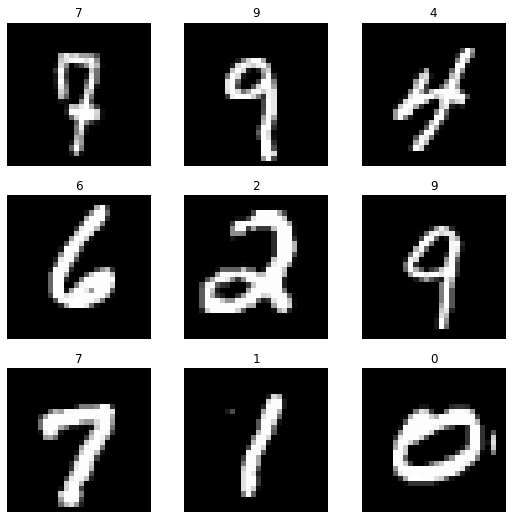

In [18]:
#colab
dls.show_batch()

Create a Fastai CNN Learner

In [19]:
#colab
learner = cnn_learner(dls, resnet18, metrics=accuracy)
                      

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [20]:
learner.xla_opt

XLAOptCallback

In [21]:
learner.fine_tune(4, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy,time
0,1.440835,0.863336,0.730300,01:47
1,0.861288,0.563215,0.820400,01:31
2,0.564402,0.372318,0.881300,01:33
3,0.371366,0.261359,0.916800,01:31


epoch,train_loss,valid_loss,accuracy,time
0,0.124727,0.077032,0.976500,01:44
1,0.063148,0.053012,0.984100,01:34
2,0.024674,0.045385,0.986900,01:34
3,0.009885,0.042435,0.988100,01:35


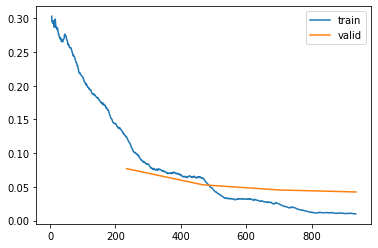

In [22]:
learner.recorder.plot_loss()